In [ ]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [ ]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
import trace_mode

In [3]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [4]:
####  No squeezing here.

#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SRMHR_Rc_orig = kat.SRMHR.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

In [5]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [23]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

SRMRoc_offset = []
max_offset = .5 #50cm Roc change in SRM curvature
steps = 10

### modulated q's at the face of SRMHR
SRMY_q1_x_list = []
SRMY_q1_y_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
q_BS_SRCY_x = []
q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
q_BS_ITMY_x = []
q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
q_BS_OMC_x = []
q_BS_OMC_y = []

### overlaps
overlap_SRC_to_ARM_x = []
overlap_SRC_to_ARM_y = []

overlap_OMC_to_ARM_x = []
overlap_OMC_to_ARM_y = []

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []


for i in range(0,steps,1):
    dRc = (float(i)/steps) * max_offset
    SRMRoc_offset.append(dRc)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands(add_squeezing)
    basekat1.parseCommands("maxtem "+str(2))
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMHR_Roc
    SRMHR_Rc_new = SRMHR_Rc_orig + dRc
    kat1.SRMHR.Rcx.value = SRMHR_Rc_new
    kat1.SRMHR.Rcy.value = SRMHR_Rc_new

    kat1.SRMHR.T.value = 1
    kat1.SRMHR.R.value = 0
    kat1.SRMHR.L.value = 0


    #Run and extract the q's at the OFI and SRMHR
    out_new_SRM_roc = kat1.run()
    SRCTL_q1_x = out_new_SRM_roc["SRCoutx"]
    SRCTL_q1_y = out_new_SRM_roc["SRCouty"]
    SRMY_q1_x = out_new_SRM_roc["SRMYqx"]
    SRMY_q1_y = out_new_SRM_roc["SRMYqy"]
    SRMY_q1_x_list.append(SRMY_q1_x)
    SRMY_q1_y_list.append(SRMY_q1_y)
    
    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')
    q_BS_SRCY_x.append(srcx)
    q_BS_SRCY_y.append(srcy)
    
    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')
    q_BS_ITMY_x.append(ARMx)
    q_BS_ITMY_y.append(ARMy)

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')
    q_BS_OMC_x.append(OMCx)
    q_BS_OMC_y.append(OMCy)

    overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))

    #### Extract the mode at the SRMAR w.r.t the ARM
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavXARM.enabled = True
    kat1.cavYARM.enabled = True

    get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
    get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)

    #### Extract the mode at the OFI w.r.t the OMC
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavOMC.enabled = True
    get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)
    get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
    get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [25]:
# Finally, we use the q_in and q_out to create an anti-lensing effect with a telescoping array between
# the SRM and OFI
darm_list = []
freq = []

SRCTL_q3_x_list = []
SRCTL_q3_y_list = []

SRMY_q3_x_list =[]
SRMY_q3_y_list =[]

f1_list = []
f2_list = []

for i in range(0,steps,1):
    basekat3 = pykat.finesse.kat() 
    basekat3.loadKatFile(katfile)
    basekat3.parseCommands(darm_commands)
    basekat3.parseCommands(amplitude_detectors)
    basekat3.parseCommands(pds)
    basekat3.parseCommands(add_squeezing)
    basekat3.parseCommands("maxtem "+str(2))
    basekat3.undumpNodes()
    kat3=basekat3.deepcopy()
    kat3.verbose = False
    
    SRMHR_Rc = kat.SRMHR.Rc
    dRc = SRMRoc_offset[i]
    
    kat3.SRMHR.Rcx.value = SRMHR_Rc + dRc
    kat3.SRMHR.Rcy.value = SRMHR_Rc + dRc

    kat3.SRMHR.T.value = 1
    kat3.SRMHR.R.value = 0
    kat3.SRMHR.L.value = 0

    
    #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[i]
    q2 = q_refout_x_list[i]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat3.lSRMTT1.L.value = d1
    kat3.SRMTT1.f.value = f1
    kat3.lSRMTT2.L.value = d2
    kat3.SRMTT2.f.value = f2
    kat3.lIBAin.L.value = d3

    out3 = kat3.run()

    SRCTL_q3_x = out3["SRCoutx"]
    SRCTL_q3_y = out3["SRCouty"]

    SRMY_q3_x = out3["SRMYqx"]
    SRMY_q3_y = out3["SRMYqy"]


    SRCTL_q3_x_list.append(SRCTL_q3_x)
    SRMY_q3_x_list.append(SRMY_q3_x)

    freq.append(out3.x)
    darm_list.append(out3['NSR_with_RP'])
    
    f1_list.append(f1)
    f2_list.append(f2) 


Successfully Mode-Matched! >99.9% overlap
f1 is -808654599237.4752
f2 is 808654599339.3179
Successfully Mode-Matched! >99.9% overlap
f1 is 1006390977398.1141
f2 is -1006390978183.3511
Successfully Mode-Matched! >99.9% overlap
f1 is 1788029628732.7031
f2 is -1787852173321.9722
Successfully Mode-Matched! >99.9% overlap
f1 is -1401789628004.2007
f2 is 1401789627473.6963
Successfully Mode-Matched! >99.9% overlap
f1 is 9936237268035.084
f2 is -9936236701238.027
Successfully Mode-Matched! >99.9% overlap
f1 is 576903814395.9293
f2 is -576866866540.5226
Successfully Mode-Matched! >99.9% overlap
f1 is -1225385926772.4634
f2 is 1225385926772.4634
Successfully Mode-Matched! >99.9% overlap
f1 is -1930389894615.6685
f2 is 1930183059740.2966
Successfully Mode-Matched! >99.9% overlap
f1 is -1181272033408.6548
f2 is 1181272033408.6548
Successfully Mode-Matched! >99.9% overlap
f1 is -3400226219230.2725
f2 is 3400226211659.0864


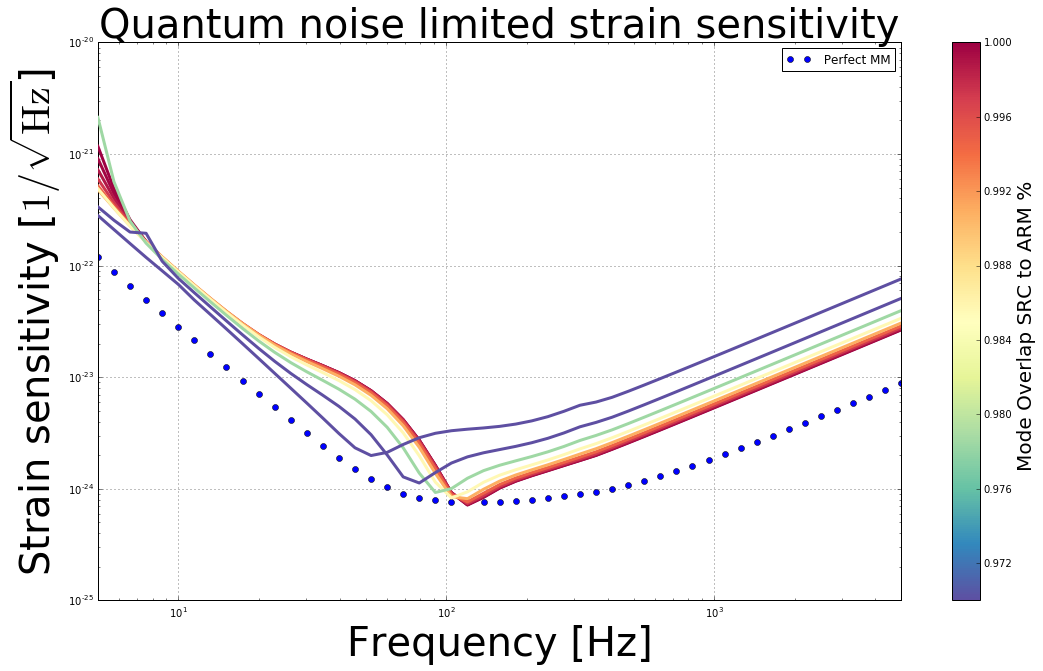

In [26]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0.97, 1.0)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(overlap_SRC_to_ARM_x[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)

    
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

pl.title("Quantum noise limited strain sensitivity",fontsize=40)
pl.xlim(freq[0].min(),freq[0].max())

pl.grid(True, zorder=-1)
pl.legend()

pl.xlabel("Frequency [Hz]",fontsize=40)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=40)


cb = pl.colorbar(s_m)
cb.set_label("Mode Overlap SRC to ARM % ", fontsize = 20)
cb.ax.tick_params(labelsize=10) 
cb.update_ticks()


pl.show()

In [27]:
#Verify that the maxtem is suitable by increasing the maxtem
#to see that the cconverge.
katfile_findtem = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_findTEM.kat"

dr = SRMRoc_offset[-1]
SRM_Rc = kat.SRMHR.Rc


D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

kat3.lSRMTT1.L.value = d1
kat3.SRMTT1.f.value = f1_list[-1]
kat3.lSRMTT2.L.value = d2
kat3.SRMTT2.f.value = f2_list[-1]
kat3.lIBAin.L.value = d3

darm1 = []
maxtem=6
for i in range(0,maxtem,1):
    basekat4 = pykat.finesse.kat() 
    basekat4.loadKatFile(katfile_findtem)
    basekat4.parseCommands(darm_commands)
    basekat4.parseCommands("maxtem "+str(i))
    basekat4.parseCommands(add_squeezing)
    basekat4.parseCommands(cav_commands_SRX_first)
    basekat4.undumpNodes() #undump the vacuum nodes
    kat4=basekat4.deepcopy() #copy kat code
    kat4.verbose = False
    kat4.SRMHR.Rcx.value = SRM_Rc + dr
    kat4.SRMHR.Rcy.value = SRM_Rc + dr
    kat4.lSRMTT1.L.value = d1
    kat4.SRMTT1.f.value = f1_list[-1]
    kat4.lSRMTT2.L.value = d2
    kat4.SRMTT2.f.value = f2_list[-1]
    kat4.lIBAin.L.value = d3
    kat4.SRMHR.T.value = 1
    kat4.SRMHR.R.value = 0
    kat4.SRMHR.L.value = 0

    out4 = kat4.run()
    darm1.append(out4['NSR_with_RP'])

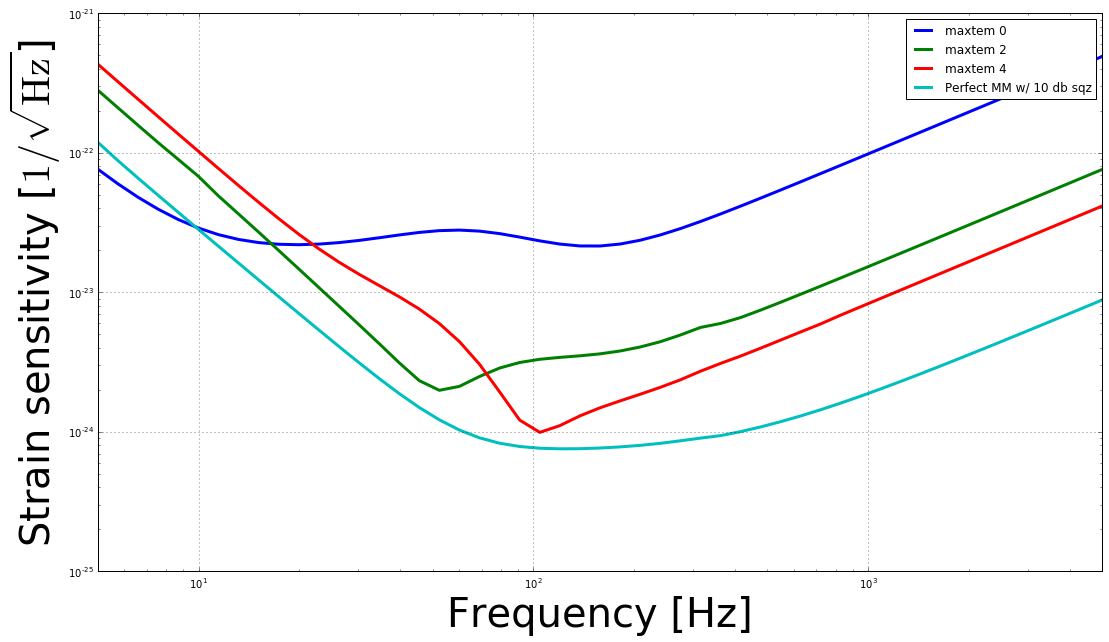

In [28]:
pl.figure(figsize=(18, 10), dpi=80)

for i in range(0,maxtem,2):
    pl.loglog(freq[0], np.real(darm1[i]),linewidth=3, label="maxtem "+str(i))
    pl.xlim(freq[0].min(),freq[0].max())
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),linewidth=3,label='Perfect MM w/ 10 db sqz')


pl.xlabel("Frequency [Hz]",fontsize=40)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=40)
pl.grid(True, zorder=-1)
pl.legend()
